In [1]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
db_path = os.path.join(os.path.dirname(os.getcwd()), 'data/financials.db')
con = sqlite3.connect(db_path)
data = pd.read_sql("SELECT * FROM economic_indicators", con=con, index_col="id")

In [3]:
data

,date,value,economic_indicator,interval,unit
id,,,,,
0,2024-06-01 00:00:00,5.33,Effective Federal Funds Rate,monthly,percent
1,2024-05-01 00:00:00,5.33,Effective Federal Funds Rate,monthly,percent
2,2024-04-01 00:00:00,5.33,Effective Federal Funds Rate,monthly,percent
3,2024-03-01 00:00:00,5.33,Effective Federal Funds Rate,monthly,percent
4,2024-02-01 00:00:00,5.33,Effective Federal Funds Rate,monthly,percent
...,...,...,...,...,...
9390,1939-05-01 00:00:00,30145.00,Total Nonfarm Payroll,monthly,thousands of persons
9391,1939-04-01 00:00:00,29786.00,Total Nonfarm Payroll,monthly,thousands of persons
9392,1939-03-01 00:00:00,29804.00,Total Nonfarm Payroll,monthly,thousands of persons


In [4]:
def convert_maturity(maturity_string):
    num, range = maturity_string.split("-")
    if range == "Month":
        return int(num)
    else:
        return int(num) * 12

In [5]:
treasury_data = data[data.economic_indicator.str.contains("Treasury")] \
    .assign(maturity = lambda x: x['economic_indicator'].str.split(" ").str[0]) \
        [['date', 'value', 'maturity']]

In [6]:
treasury_data['maturity'] = treasury_data['maturity'].apply(convert_maturity)
treasury_data['date'] = pd.to_datetime(treasury_data['date'])
treasury_data.rename({'value': 'yield'},axis=1, inplace=True)

In [7]:
treasury_data

,date,yield,maturity
id,,,
840,2024-06-01,5.51,3
841,2024-05-01,5.46,3
842,2024-04-01,5.44,3
843,2024-03-01,5.47,3
844,2024-02-01,5.44,3
...,...,...,...
4865,1977-06-01,7.64,360
4866,1977-05-01,7.80,360
4867,1977-04-01,7.73,360


In [8]:
def plot_treasury_months(year, months):
    
    num_months = len(months)
    num_cols = 3  
    num_rows = (num_months + num_cols - 1) // num_cols 
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, num_rows * 4))
    axes = axes.flatten()
    
    for idx, month in enumerate(months):
        ax = axes[idx]
        dat = treasury_data[(treasury_data.date.dt.month == month) & (treasury_data.date.dt.year == year)]
        sns.lineplot(data=dat, x='maturity', y='yield', ax=ax)
        ax.set_xlabel('Maturity')
        ax.set_ylabel('Yield')
        ax.set_title(f'Yield Curve for {month}/1/{year}')

    for i in range(num_months, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

    

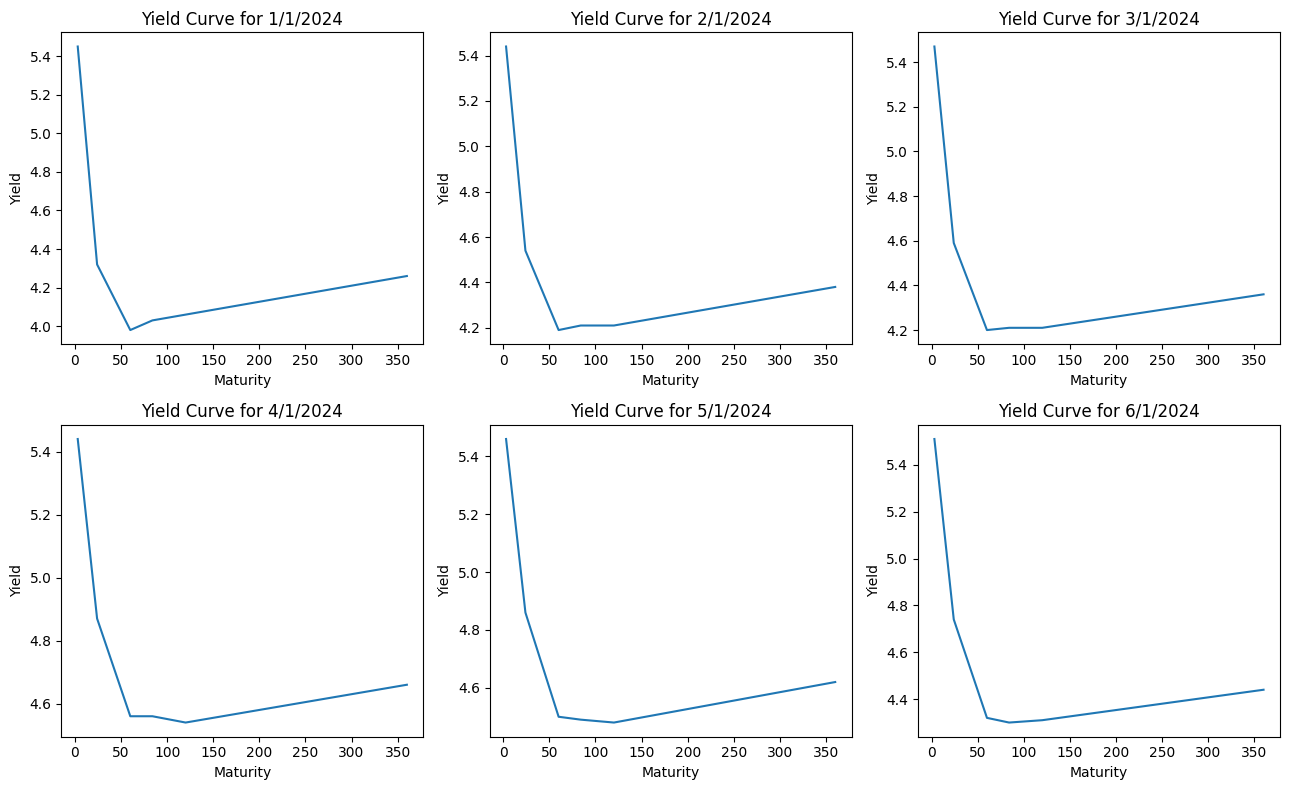

In [9]:
plot_treasury_months(year=2024, months=[1, 2, 3, 4, 5,6])

In [10]:
from scipy.spatial.distance import pdist, squareform

In [11]:
pivoted_data = treasury_data.pivot(index='date', columns='maturity', values='yield').dropna(axis=0)

In [12]:
pivoted_data.head()

maturity,3,24,60,84,120,360
date,,,,,,
1981-09-01,15.61,16.46,15.93,15.65,15.32,14.67
1981-10-01,14.23,15.54,15.41,15.33,15.15,14.68
1981-11-01,11.35,12.88,13.38,13.42,13.39,13.35
1981-12-01,11.32,13.29,13.60,13.62,13.72,13.45
1982-01-01,12.92,14.57,14.65,14.67,14.59,14.22


In [13]:
dist_matrix = squareform(pdist(pivoted_data, metric='euclidean'))
dist_df = pd.DataFrame(dist_matrix, index=pivoted_data.index, columns=pivoted_data.index)

In [14]:
dist_df.loc["2024-06-01"].loc[:'2021-12-01'].sort_values(ascending=True).head()

date
2007-03-01    0.648305
2006-11-01    0.697280
2006-12-01    0.719931
2007-04-01    0.871493
2007-02-01    0.875957
Name: 2024-06-01 00:00:00, dtype: float64

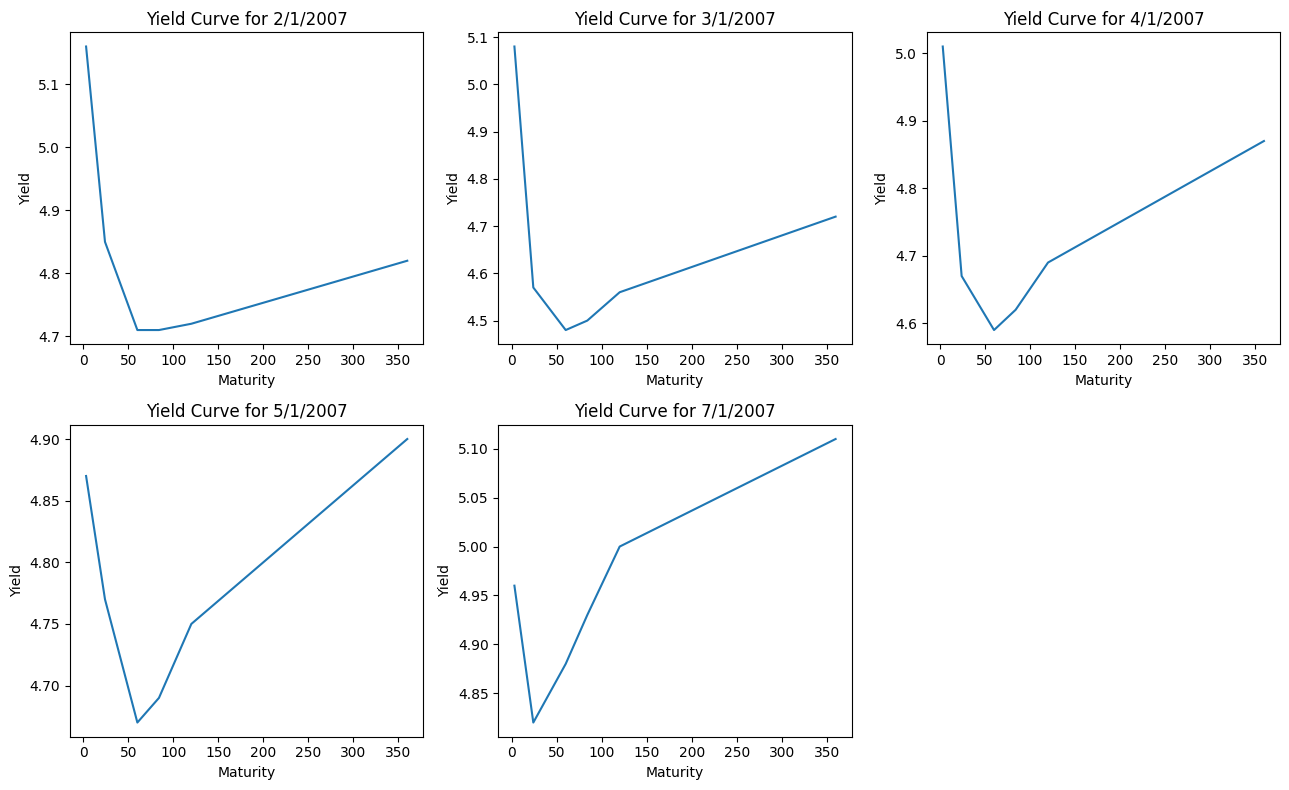

In [15]:
plot_treasury_months(year=2007, months=[2,3,4,5,7])

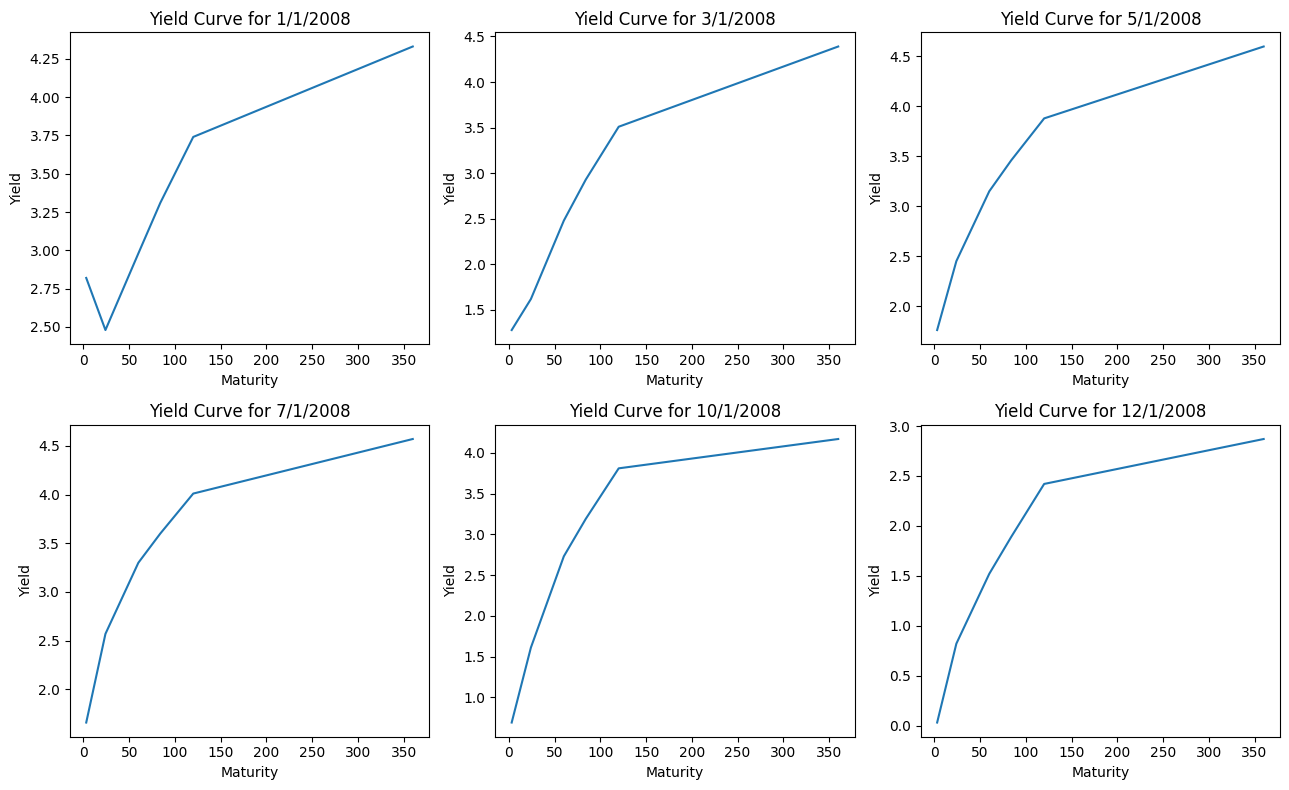

In [16]:
plot_treasury_months(year=2008, months=[1,3,5,7,10,12])

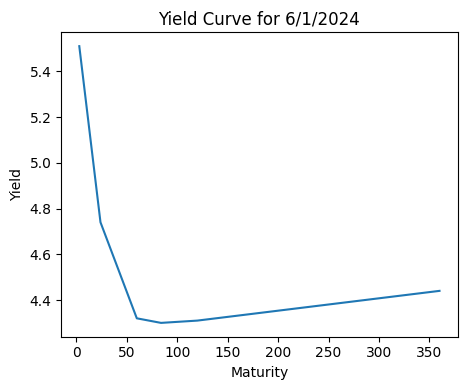

In [17]:
plot_treasury_months(year=2024, months=[6])

In [18]:
dist_df.loc["2024-06-01"].loc['2008-01-01':'2008-12-01'].sort_values(ascending=True).head()

date
2008-01-01    3.931463
2008-06-01    4.255079
2008-07-01    4.600946
2008-05-01    4.646676
2008-08-01    4.668833
Name: 2024-06-01 00:00:00, dtype: float64

In [19]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(dist_df.loc["2020-06-01":, "2020-06-01":], annot=True, cmap='viridis', xticklabels=dist_df.loc["2020-06-01":, "2020-06-01":].columns.date, yticklabels=dist_df.loc["2020-06-01":, "2020-06-01":].columns.date)
# plt.title('Euclidean Distance Between Yield Curves (after January 2024)')
# plt.show()

In [20]:
pivoted_data.loc["2005-01-01":]

maturity,3,24,60,84,120,360
date,,,,,,
2005-01-01,2.37,3.22,3.71,3.97,4.22,4.77
2005-02-01,2.58,3.38,3.77,3.97,4.17,4.56
2005-03-01,2.80,3.73,4.17,4.33,4.50,4.77
2005-04-01,2.84,3.65,4.00,4.16,4.34,4.65
2005-05-01,2.90,3.64,3.85,3.94,4.14,4.49
...,...,...,...,...,...,...
2024-02-01,5.44,4.54,4.19,4.21,4.21,4.38
2024-03-01,5.47,4.59,4.20,4.21,4.21,4.36
2024-04-01,5.44,4.87,4.56,4.56,4.54,4.66


In [21]:
modeling_data = pivoted_data.copy()

In [22]:
modeling_data.rename({3: "3M", 24:f"{24//12}Y", 60:f"{60//12}Y", 84:f"{84//12}Y", 120:f"{120//12}Y", 360:f"{360//12}Y"}, axis=1, inplace=True)

In [23]:
modeling_data.head()

maturity,3M,2Y,5Y,7Y,10Y,30Y
date,,,,,,
1981-09-01,15.61,16.46,15.93,15.65,15.32,14.67
1981-10-01,14.23,15.54,15.41,15.33,15.15,14.68
1981-11-01,11.35,12.88,13.38,13.42,13.39,13.35
1981-12-01,11.32,13.29,13.60,13.62,13.72,13.45
1982-01-01,12.92,14.57,14.65,14.67,14.59,14.22


In [24]:
modeling_data["3M_lag"] = modeling_data["3M"].shift(1)
modeling_data["2Y_lag"] = modeling_data["2Y"].shift(1)
modeling_data["5Y_lag"] = modeling_data["5Y"].shift(1)
modeling_data["7Y_lag"] = modeling_data["7Y"].shift(1)
modeling_data["10Y_lag"] = modeling_data["10Y"].shift(1)
modeling_data["30Y_lag"] = modeling_data["30Y"].shift(1)

In [25]:
modeling_data.head()

maturity,3M,2Y,5Y,7Y,10Y,30Y,3M_lag,2Y_lag,5Y_lag,7Y_lag,10Y_lag,30Y_lag
date,,,,,,,,,,,,
1981-09-01,15.61,16.46,15.93,15.65,15.32,14.67,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-01,14.23,15.54,15.41,15.33,15.15,14.68,15.61,16.46,15.93,15.65,15.32,14.67
1981-11-01,11.35,12.88,13.38,13.42,13.39,13.35,14.23,15.54,15.41,15.33,15.15,14.68
1981-12-01,11.32,13.29,13.60,13.62,13.72,13.45,11.35,12.88,13.38,13.42,13.39,13.35
1982-01-01,12.92,14.57,14.65,14.67,14.59,14.22,11.32,13.29,13.60,13.62,13.72,13.45


In [26]:
modeling_data.dropna(inplace=True)

In [27]:
modeling_data.head()

maturity,3M,2Y,5Y,7Y,10Y,30Y,3M_lag,2Y_lag,5Y_lag,7Y_lag,10Y_lag,30Y_lag
date,,,,,,,,,,,,
1981-10-01,14.23,15.54,15.41,15.33,15.15,14.68,15.61,16.46,15.93,15.65,15.32,14.67
1981-11-01,11.35,12.88,13.38,13.42,13.39,13.35,14.23,15.54,15.41,15.33,15.15,14.68
1981-12-01,11.32,13.29,13.60,13.62,13.72,13.45,11.35,12.88,13.38,13.42,13.39,13.35
1982-01-01,12.92,14.57,14.65,14.67,14.59,14.22,11.32,13.29,13.60,13.62,13.72,13.45
1982-02-01,14.28,14.82,14.54,14.46,14.43,14.22,12.92,14.57,14.65,14.67,14.59,14.22


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

In [29]:
modeling_data.columns

Index(['3M', '2Y', '5Y', '7Y', '10Y', '30Y', '3M_lag', '2Y_lag', '5Y_lag',
       '7Y_lag', '10Y_lag', '30Y_lag'],
      dtype='object', name='maturity')

In [30]:
X = modeling_data[['3M_lag', '2Y_lag', '5Y_lag','7Y_lag', '10Y_lag', '30Y_lag']]
Y = modeling_data[['3M', '2Y', '5Y', '7Y', '10Y', '30Y']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [32]:
Y.columns

Index(['3M', '2Y', '5Y', '7Y', '10Y', '30Y'], dtype='object', name='maturity')

In [33]:
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [34]:
all_mses = []
for i, col in enumerate(Y.columns):
    mse = mean_squared_error(y_test[col], y_pred[:, i])
    all_mses.append(mse)
    print(f'Mean Squared Error for {col}: {mse}')
print(sum(all_mses))

Mean Squared Error for 3M: 0.03328241217170342
Mean Squared Error for 2Y: 0.032313317709818434
Mean Squared Error for 5Y: 0.038579437341867175
Mean Squared Error for 7Y: 0.039483446754913595
Mean Squared Error for 10Y: 0.038055872962541155
Mean Squared Error for 30Y: 0.03436861963137174
0.2160831065722155


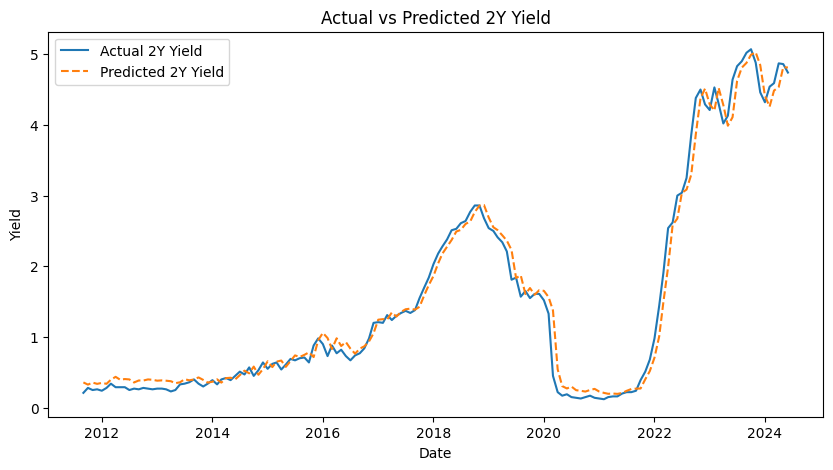

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test['2Y'], label='Actual 2Y Yield')
plt.plot(y_test.index, y_pred[:, Y.columns.get_loc('2Y')], label='Predicted 2Y Yield', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted 2Y Yield')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.show()

In [36]:
init = model.predict(pd.DataFrame(X_test.loc["2024-06-01"]).T).squeeze()
predictions = [pd.DataFrame([dict(zip(X_test.columns.values, init))])]
# pd.DataFrame(X_test.loc["2024-06-01"]).T
for _ in range(6):
    # temp = pd.DataFrame([dict(zip(X_test.columns.values, predictions[-1]))])
    res = model.predict(predictions[-1]).squeeze()
    predictions.append(pd.DataFrame([dict(zip(X_test.columns.values, res))]))

In [37]:
full_res = pd.concat(predictions)

In [38]:
full_res.index = pd.date_range(start='2024-07-01', periods=7, freq='ME')

In [39]:
full_res = full_res.rename(dict(zip(X_test.columns.values,y_test.columns.values)),axis=1)

In [40]:
plotting_df = full_res.reset_index(names="date").melt(id_vars="date",var_name="maturity", value_name="pred_yield")

In [44]:
full_res

,3M,2Y,5Y,7Y,10Y,30Y
2024-07-31,5.339343,4.811495,4.503269,4.511571,4.505733,4.651349
2024-08-31,5.225407,4.764289,4.504688,4.529919,4.529027,4.681993
2024-09-30,5.117831,4.718475,4.504584,4.545517,4.550182,4.711811
2024-10-31,5.016247,4.674109,4.503225,4.558760,4.569448,4.740716
2024-11-30,4.920297,4.631216,4.500831,4.569979,4.587036,4.768644
2024-12-31,4.829631,4.589799,4.497582,4.579454,4.603128,4.795556
2025-01-31,4.743913,4.549841,4.493629,4.587418,4.617874,4.821426


In [41]:
def pred_plot_treasury_months(year, months):
    
    num_months = len(months)
    num_cols = 3  
    num_rows = (num_months + num_cols - 1) // num_cols 
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, num_rows * 4))
    axes = axes.flatten()
    
    for idx, month in enumerate(months):
        ax = axes[idx]
        dat = plotting_df[(plotting_df.date.dt.month == month) & (plotting_df.date.dt.year == year)]
        sns.lineplot(data=dat, x='maturity', y='pred_yield', ax=ax)
        ax.set_xlabel('Maturity')
        ax.set_ylabel('Yield')
        ax.set_title(f'Yield Curve for {month}/1/{year}')

    for i in range(num_months, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

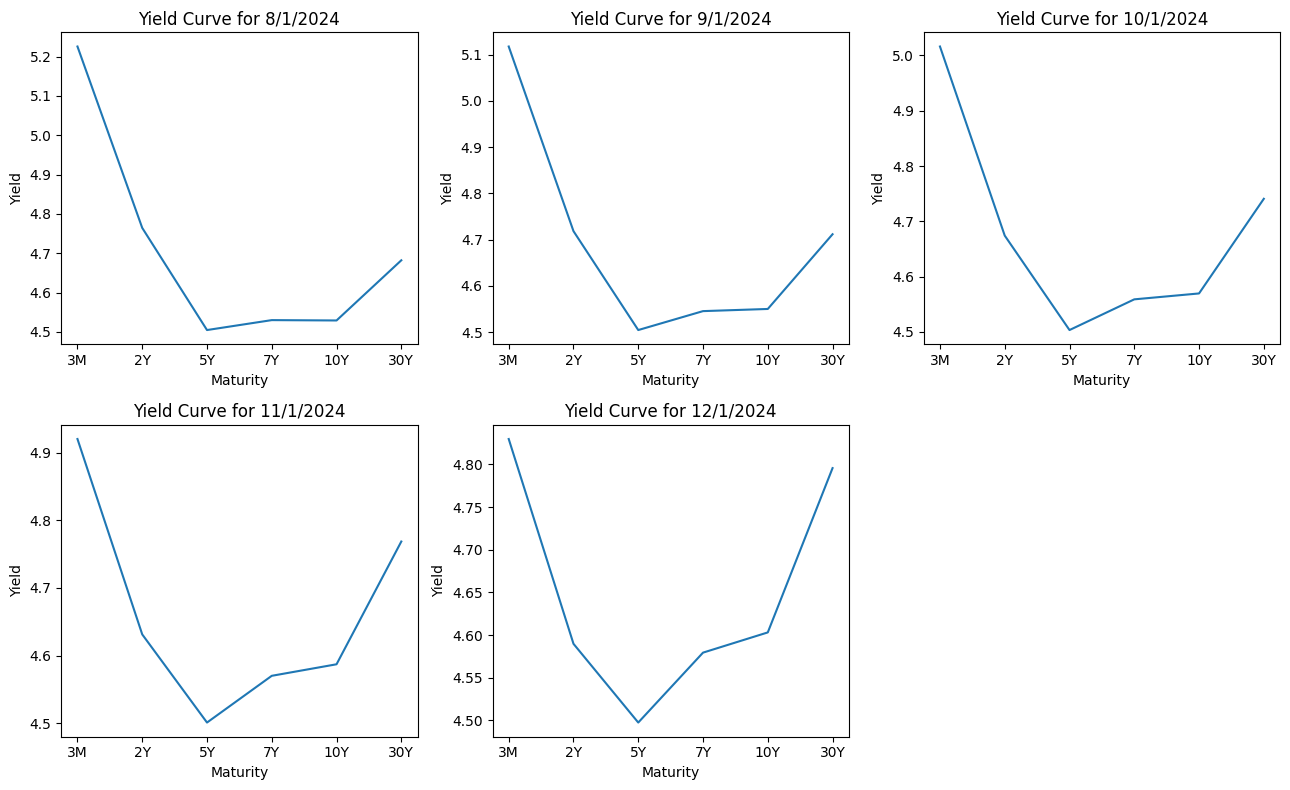

In [42]:
pred_plot_treasury_months(year=2024,months=[8,9,10,11,12])